# An Introduction to SageMaker Neural Topic Model

***Unsupervised representation learning and topic extraction using Neural Topic Model***

1. [Introduction](#Introduction)
1. [Data Preparation](#Data-Preparation)
1. [Model Training](#Model-Training)
1. [Model Hosting and Inference](#Model-Hosting-and-Inference)
1. [Model Exploration](#Model-Exploration)


In [20]:
# update sagemake package, in order to use write_spmatrix_to_sparse_tensor in the next cell
# !pip install -U sagemaker
# !pip install konlpy

## Fetching Data Set

First let's define the folder to hold the data and clean the content in it which might be from previous experiments.

In [2]:
%store -r s3_negative_path

In [3]:
import pandas as pd
df = pd.read_csv(s3_negative_path)
data = df['document'].tolist()

In [4]:
data[0:13]

['아 더빙.. 진짜 짜증나네요 목소리',
 '너무재밓었다그래서보는것을추천한다',
 '교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정',
 '막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.',
 '원작의 긴장감을 제대로 살려내지못했다.',
 '별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단 낫겟다 납치.감금만반복반복..이드라마는 가족도없다 연기못하는사람만모엿네',
 '울면서 손들고 횡단보도 건널때 뛰쳐나올뻔 이범수 연기 드럽게못해',
 '취향은 존중한다지만 진짜 내생에 극장에서 본 영화중 가장 노잼 노감동임 스토리도 어거지고 감동도 어거지',
 '굿바이 레닌 표절인것은 이해하는데 왜 뒤로 갈수록 재미없어지냐',
 '재미없다 지루하고. 같은 음식 영화인데도 바베트의 만찬하고 넘 차이남....바베트의 만찬은 이야기도 있고 음식 보는재미도 있는데 ; 이건 볼게없다 음식도 별로 안나오고, 핀란드 풍경이라도 구경할랫는데 그것도 별로 안나옴 ㅡㅡ',
 '주제는 좋은데 중반부터 지루하다',
 '다 짤랐을꺼야. 그래서 납득할 수 없었던거야.. 그럴꺼야.. 꼭 그랬던걸꺼야..',
 '카밀라벨 발연기']

In [5]:
len(data)

10000

---
In the following cell, we use a tokenizer and a lemmatizer from `nltk`. In the list comprehension, we implement a simple rule: only consider words that are longer than 2 characters, start with a letter and match the `token_pattern`.

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

import numpy as np
np.random.seed(0)
 
from konlpy.tag import Twitter
twitter = Twitter()
 
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
 
# tokenizer : 문장에서 색인어 추출을 위해 명사,동사,알파벳,숫자 정도의 단어만 뽑아서 normalization, stemming 처리하도록 함
def tokenizer(raw, pos=["Noun","Alpha","Verb","Number"], stopword=[]):
    return [
        word for word, tag in twitter.pos(
            raw, 
            norm=True,   # normalize 그랰ㅋㅋ -> 그래ㅋㅋ
            stem=True    # stemming 바뀌나->바뀌다
            )
            if len(word) > 1 and tag in pos and word not in stopword
        ]

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/konlpy/tag/_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


In [8]:
%%time 

vocab_size = 2000
vectorize = CountVectorizer(
    tokenizer=tokenizer, 
    min_df = 2,
    max_df = 0.8,
                # 예제로 보기 좋게 1번 정도만 노출되는 단어들은 무시하기로 했다
                # min_df = 0.01 : 문서의 1% 미만으로 나타나는 단어 무시
                # min_df = 10 : 문서에 10개 미만으로 나타나는 단어 무시
                # max_df = 0.80 : 문서의 80% 이상에 나타나는 단어 무시
                # max_df = 10 : 10개 이상의 문서에 나타나는 단어 무시
    max_features = vocab_size
)
 
# 문장에서 노출되는 feature(특징이 될만한 단어) 수를 합한 Document Term Matrix(이하 DTM) 을 리턴한다
X = vectorize.fit_transform(data)
 
print(
    'fit_transform, (sentence {}, feature {})'.format(X.shape[0], X.shape[1])
)
# fit_transform, (sentence 5, feature 7)
  
print(X.toarray())



fit_transform, (sentence 10000, feature 2000)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
CPU times: user 57.1 s, sys: 888 ms, total: 58 s
Wall time: 36.5 s


In [9]:
vocab_list = vectorize.get_feature_names()
print('vocab size:', len(vocab_list))
vocab_list[300:310]

vocab size: 2000


['깨다', '깨지다', '꺼지다', '꼴리다', '꾸다', '끄다', '끊기다', '끌다', '끌리다', '끝나다']

In [11]:
def prepro_data(raw_vectors, threshold = 10):
    '''
    threshold 만큼의 단어이하의 문장은 삭제
    '''
    vectors = raw_vectors.copy()
    threshold = 2
    vectors = vectors[np.array(vectors.sum(axis=1)>threshold).reshape(-1,)]
    print('removed short docs (<{} words)'.format(threshold))        
    print(vectors.shape)
    return vectors

vectors = prepro_data(X)

removed short docs (<2 words)
(6947, 2000)


The output from `CountVectorizer` are sparse matrices with their elements being integers. 

In [12]:
print(type(vectors), vectors.dtype)
print(vectors[0])

<class 'scipy.sparse.csr.csr_matrix'> int64
  (0, 478)	1
  (0, 1677)	1
  (0, 695)	1


Because all the parameters (weights and biases) in the NTM model are `np.float32` type we'd need the input data to also be in `np.float32`. It is better to do this type-casting upfront rather than repeatedly casting during mini-batch training.

In [13]:
import scipy.sparse as sparse
vectors = sparse.csr_matrix(vectors, dtype=np.float32)
print(type(vectors), vectors.dtype)

<class 'scipy.sparse.csr.csr_matrix'> float32


As a common practice in modeling training, we should have a training set, a validation set, and a test set. The training set is the set of data the model is actually being trained on. But what we really care about is not the model's performance on training set but its performance on future, unseen data. Therefore, during training, we periodically calculate scores (or losses) on the validation set to validate the performance of the model on unseen data. By assessing the model's ability to generalize we can stop the training at the optimal point via early stopping to avoid over-training. 

Note that when we only have a training set and no validation set, the NTM model will rely on scores on the training set to perform early stopping, which could result in over-training. Therefore, we recommend always supply a validation set to the model.

Here we use 80% of the data set as the training set and the rest for validation set and test set. We will use the validation set in training and use the test set for demonstrating model inference.

In [14]:
n_train = int(0.8 * vectors.shape[0])

# split train and test
train_vectors = vectors[:n_train, :]
test_vectors = vectors[n_train:, :]

# further split test set into validation set (val_vectors) and test  set (test_vectors)
n_test = test_vectors.shape[0]
val_vectors = test_vectors[:n_test//2, :]
test_vectors = test_vectors[n_test//2:, :]

In [15]:
print(train_vectors.shape, test_vectors.shape, val_vectors.shape)

(5557, 2000) (695, 2000) (695, 2000)


### Setup AWS Credentials

We first need to specify data locations and access roles. In particular, we need the following data:

- The S3 `bucket` and `prefix` that you want to use for training and model data.  This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM `role` is used to give training and hosting access to your data. See the documentation for how to create these.  Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the boto regexp with a the appropriate full IAM role arn string(s).

In [16]:
import os
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()

sess = sagemaker.Session()
bucket=sess.default_bucket()

In [18]:
prefix = 'ml-architect/ntm/naver-movie-review'

train_prefix = os.path.join(prefix, 'train')
val_prefix = os.path.join(prefix, 'val')
output_prefix = os.path.join(prefix, 'output')

s3_train_data = os.path.join('s3://', bucket, train_prefix)
s3_val_data = os.path.join('s3://', bucket, val_prefix)
output_path = os.path.join('s3://', bucket, output_prefix)
print('Training set location', s3_train_data)
print('Validation set location', s3_val_data)
print('Trained model will be saved at', output_path)

Training set location s3://sagemaker-ap-northeast-2-057716757052/ml-architect/ntm/naver-movie-review/train
Validation set location s3://sagemaker-ap-northeast-2-057716757052/ml-architect/ntm/naver-movie-review/val
Trained model will be saved at s3://sagemaker-ap-northeast-2-057716757052/ml-architect/ntm/naver-movie-review/output


Here we define a helper function to convert the data to RecordIO Protobuf format and upload it to S3. In addition, we will have the option to split the data into several parts specified by `n_parts`.

The algorithm inherently supports multiple files in the training folder ("channel"), which could be very helpful for large data set. In addition, when we use distributed training with multiple workers (compute instances), having multiple files allows us to distribute different portions of the training data to different workers conveniently.

Inside this helper function we use `write_spmatrix_to_sparse_tensor` function provided by [SageMaker Python SDK](https://github.com/aws/sagemaker-python-sdk) to convert scipy sparse matrix into RecordIO Protobuf format.

In [21]:
def split_convert_upload(sparray, bucket, prefix, fname_template='data_part{}.pbr', n_parts=2):
    import io
    import boto3
    import sagemaker.amazon.common as smac
    
    chunk_size = sparray.shape[0]// n_parts
    for i in range(n_parts):

        # Calculate start and end indices
        start = i*chunk_size
        end = (i+1)*chunk_size
        if i+1 == n_parts:
            end = sparray.shape[0]
        
        # Convert to record protobuf
        buf = io.BytesIO()
        smac.write_spmatrix_to_sparse_tensor(array=sparray[start:end], file=buf, labels=None)
        buf.seek(0)
        
        # Upload to s3 location specified by bucket and prefix
        fname = os.path.join(prefix, fname_template.format(i))
        boto3.resource('s3').Bucket(bucket).Object(fname).upload_fileobj(buf)
        print('Uploaded data to s3://{}'.format(os.path.join(bucket, fname)))

In [22]:
split_convert_upload(train_vectors, bucket=bucket, prefix=train_prefix, fname_template='train_part{}.pbr', n_parts=8)
split_convert_upload(val_vectors, bucket=bucket, prefix=val_prefix, fname_template='val_part{}.pbr', n_parts=1)

Uploaded data to s3://sagemaker-ap-northeast-2-057716757052/ml-architect/ntm/naver-movie-review/train/train_part0.pbr
Uploaded data to s3://sagemaker-ap-northeast-2-057716757052/ml-architect/ntm/naver-movie-review/train/train_part1.pbr
Uploaded data to s3://sagemaker-ap-northeast-2-057716757052/ml-architect/ntm/naver-movie-review/train/train_part2.pbr
Uploaded data to s3://sagemaker-ap-northeast-2-057716757052/ml-architect/ntm/naver-movie-review/train/train_part3.pbr
Uploaded data to s3://sagemaker-ap-northeast-2-057716757052/ml-architect/ntm/naver-movie-review/train/train_part4.pbr
Uploaded data to s3://sagemaker-ap-northeast-2-057716757052/ml-architect/ntm/naver-movie-review/train/train_part5.pbr
Uploaded data to s3://sagemaker-ap-northeast-2-057716757052/ml-architect/ntm/naver-movie-review/train/train_part6.pbr
Uploaded data to s3://sagemaker-ap-northeast-2-057716757052/ml-architect/ntm/naver-movie-review/train/train_part7.pbr
Uploaded data to s3://sagemaker-ap-northeast-2-057716757

---
# Model Training

We have created the training and validation data sets and uploaded them to S3. Next, we configure a SageMaker training job to use the NTM algorithm on the data we prepared

SageMaker uses Amazon Elastic Container Registry (ECR) docker container to host the NTM training image. The following ECR containers are currently available for SageMaker NTM training in different regions. For the latest Docker container registry please refer to [Amazon SageMaker: Common Parameters](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-algo-docker-registry-paths.html).

In [23]:
from sagemaker import image_uris, session
container = image_uris.retrieve("ntm", session.Session().boto_region_name, version="latest")

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.


The code in the cell below automatically chooses an algorithm container based on the current region. In the API call to `sagemaker.estimator.Estimator` we also specify the type and count of instances for the training job. Because the 20NewsGroups data set is relatively small, we have chosen a CPU only instance (`ml.c4.xlarge`), but do feel free to change to [other instance types](https://aws.amazon.com/sagemaker/pricing/instance-types/). NTM fully takes advantage of GPU hardware and in general trains roughly an order of magnitude faster on a GPU than on a CPU. Multi-GPU or multi-instance training further improves training speed roughly linearly if communication overhead is low compared to compute time.

In [24]:
import sagemaker
sess = sagemaker.Session()
ntm = sagemaker.estimator.Estimator(container,
                                    role, 
                                    instance_count=2, 
                                    instance_type='ml.c5.18xlarge',
                                    output_path=output_path,
                                    sagemaker_session=sess)

## Hyperparameters

Here we highlight a few hyperparameters. For information about the full list of available hyperparameters, please refer to [NTM Hyperparameters](https://docs.aws.amazon.com/sagemaker/latest/dg/ntm_hyperparameters.html).

- **feature_dim** - the "feature dimension", it should be set to the vocabulary size
- **num_topics** - the number of topics to extract
- **mini_batch_size** - this is the batch size for each worker instance. Note that in multi-GPU instances, this number will be further divided by the number of GPUs. Therefore, for example, if we plan to train on an 8-GPU machine (such as `ml.p2.8xlarge`) and wish each GPU to have 1024 training examples per batch, `mini_batch_size` should be set to 8196.
- **epochs** - the maximal number of epochs to train for, training may stop early
- **num_patience_epochs** and **tolerance** controls the early stopping behavior. Roughly speaking, the algorithm will stop training if within the last `num_patience_epochs` epochs there have not been improvements on validation loss. Improvements smaller than `tolerance` will be considered non-improvement.
- **optimizer** and **learning_rate** - by default we use `adadelta` optimizer and `learning_rate` does not need to be set. For other optimizers, the choice of an appropriate learning rate may require experimentation.



In [25]:
# num_topics = 20
num_topics = 5
ntm.set_hyperparameters(num_topics=num_topics, feature_dim=vocab_size, mini_batch_size=128, 
                        epochs=100, num_patience_epochs=5, tolerance=0.001)

Next, we need to specify how the training data and validation data will be distributed to the workers during training. There are two modes for data channels:

- `FullyReplicated`: all data files will be copied to all workers
- `ShardedByS3Key`: data files will be sharded to different workers, i.e. each worker will receive a different portion of the full data set.

At the time of writing, by default, the Python SDK will use `FullyReplicated` mode for all data channels. This is desirable for validation (test) channel but not suitable for training channel. The reason is that when we use multiple workers we would like to go through the full data set by each of them going through a different portion of the data set, so as to provide different gradients within epochs. Using `FullyReplicated` mode on training data not only results in slower training time per epoch (nearly 1.5X in this example), but also defeats the purpose of distributed training. To set the training data channel correctly we specify `distribution` to be `ShardedByS3Key` for the training data channel as follows.

In [26]:
# from sagemaker.session import s3_input
from sagemaker.inputs import TrainingInput
# s3_train = s3_input(s3_train_data, distribution='ShardedByS3Key') 
s3_train = TrainingInput(s3_train_data, distribution='ShardedByS3Key') 

Now we are ready to train. The following cell takes a few minutes to run. The command below will first provision the required hardware. You will see a series of dots indicating the progress of the hardware provisioning process. Once the resources are allocated, training logs will be displayed. With multiple workers, the log color and the ID following `INFO` identifies logs emitted by different workers.

In [27]:
ntm.fit({'train': s3_train, 'validation': s3_val_data})

2020-10-07 05:33:53 Starting - Starting the training job...
2020-10-07 05:34:02 Starting - Launching requested ML instances......
2020-10-07 05:35:04 Starting - Preparing the instances for training......
2020-10-07 05:36:01 Downloading - Downloading input data...
2020-10-07 05:36:48 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
Docker entrypoint called with argument(s): train
Running default environment configuration script
/opt/amazon/lib/python2.7/site-packages/pandas/util/nosetester.py:13: DeprecationWarning: Importing from numpy.testing.nosetester is deprecated, import from numpy.testing instead.
  from numpy.testing import nosetester
[10/07/2020 05:36:49 INFO 140554461984576] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'num_patience_epochs': u'3', u'clip_gradient': u'Inf', u'encoder_layers': u'auto', 

If you see the message

> `===== Job Complete =====`

at the bottom of the output logs then that means training successfully completed and the output NTM model was stored in the specified output path. You can also view information about and the status of a training job using the AWS SageMaker console. Just click on the "Jobs" tab and select training job matching the training job name, below:

In [28]:
print('Training job name: {}'.format(ntm.latest_training_job.job_name))

Training job name: ntm-2020-10-07-05-33-53-240


# Model Hosting and Inference

A trained NTM model does nothing on its own. We now want to use the model we computed to perform inference on data. For this example, that means predicting the topic mixture representing a given document.

We create an inference endpoint using the SageMaker Python SDK `deploy()` function from the job we defined above. We specify the instance type where inference is computed as well as an initial number of instances to spin up.

In [29]:
%%time
ntm_predictor = ntm.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

-------------!

Congratulations! You now have a functioning SageMaker NTM inference endpoint. You can confirm the endpoint configuration and status by navigating to the "Endpoints" tab in the AWS SageMaker console and selecting the endpoint matching the endpoint name, below: 

In [30]:
ntm_predictor.endpoint_name

'ntm-2020-10-07-05-39-03-921'

In [31]:
print('Endpoint name: {}'.format(ntm_predictor.endpoint_name))

Endpoint name: ntm-2020-10-07-05-39-03-921


---
## Data Serialization/Deserialization

We can pass data in a variety of formats to our inference endpoint. First, we will demonstrate passing CSV-formatted data. We make use of the SageMaker Python SDK utilities `csv_serializer` and `json_deserializer` when configuring the inference endpoint.

### Inference with CSV

In [32]:
# from sagemaker.predictor import csv_serializer, json_deserializer
from sagemaker.deserializers import JSONDeserializer
from sagemaker.serializers import CSVSerializer

# ntm_predictor.content_type = 'text/csv'
ntm_predictor.serializer = CSVSerializer()
ntm_predictor.deserializer = JSONDeserializer()

Let's pass 5 examples from the test set to the inference endpoint

In [35]:
test_data = np.array(test_vectors.todense())
results = ntm_predictor.predict(test_data[:5])
print(results)

{'predictions': [{'topic_weights': [0.1988115758, 0.2022137344, 0.198289156, 0.1970998645, 0.2035856843]}, {'topic_weights': [0.2021822631, 0.1999334544, 0.1977099329, 0.1975263804, 0.2026479691]}, {'topic_weights': [0.203534171, 0.199104473, 0.1974337399, 0.1976194084, 0.2023082078]}, {'topic_weights': [0.203706786, 0.1985468566, 0.197843343, 0.1979774833, 0.201925531]}, {'topic_weights': [0.1993484199, 0.2019989938, 0.1980570704, 0.1969904304, 0.2036051154]}]}


We can see the output format of SageMaker NTM inference endpoint is a Python dictionary with the following format.

```
{
  'predictions': [
    {'topic_weights': [ ... ] },
    {'topic_weights': [ ... ] },
    {'topic_weights': [ ... ] },
    ...
  ]
}
```

We extract the topic weights, themselves, corresponding to each of the input documents.

In [36]:
predictions = np.array([prediction['topic_weights'] for prediction in results['predictions']])
print(predictions)

[[0.19881158 0.20221373 0.19828916 0.19709986 0.20358568]
 [0.20218226 0.19993345 0.19770993 0.19752638 0.20264797]
 [0.20353417 0.19910447 0.19743374 0.19761941 0.20230821]
 [0.20370679 0.19854686 0.19784334 0.19797748 0.20192553]
 [0.19934842 0.20199899 0.19805707 0.19699043 0.20360512]]


---
### Inference with RecordIO Protobuf
The inference endpoint also supports JSON-formatted and RecordIO Protobuf, see [Common Data Formats—Inference](https://docs.aws.amazon.com/sagemaker/latest/dg/cdf-inference.html) for more information. 

At the time of writing SageMaker Python SDK does not yet have a RecordIO Protobuf serializer, but it is fairly straightforward to create one as follows.

In [37]:
# def recordio_protobuf_serializer(spmatrix):
#     import io
#     import sagemaker.amazon.common as smac
#     buf = io.BytesIO()
#     smac.write_spmatrix_to_sparse_tensor(array=spmatrix, file=buf, labels=None)
#     buf.seek(0)
#     return buf

Now we specify the serializer to be the one we just crated and `content_type` to be 'application/x-recordio-protobuf' and inference can be carried out with RecordIO Protobuf format

In [38]:
# # ntm_predictor.content_type = 'application/x-recordio-protobuf'
# ntm_predictor.serializer = recordio_protobuf_serializer
# ntm_predictor.deserializer = JSONDeserializer()
# results = ntm_predictor.predict(test_vectors[:5])
# print(results)

If you decide to compare these results to the known topic weights generated above keep in mind that SageMaker NTM discovers topics in no particular order. That is, the approximate topic mixtures computed above may be (approximate) permutations of the known topic mixtures corresponding to the same documents.

---
Now we can take a look at how the 20 topics are assigned to the 5 test documents with a bar plot.

Text(0.5, 0, 'Topic ID')

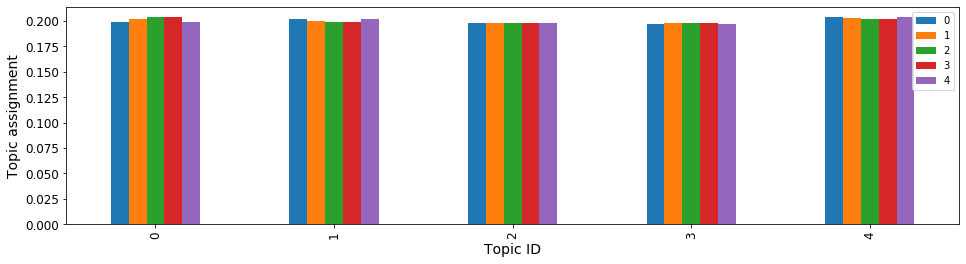

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

fs = 12
df=pd.DataFrame(predictions.T)
df.plot(kind='bar', figsize=(16,4), fontsize=fs)
plt.ylabel('Topic assignment', fontsize=fs+2)
plt.xlabel('Topic ID', fontsize=fs+2)

## Stop / Close the Endpoint

Finally, we should delete the endpoint before we close the notebook.

To restart the endpoint you can follow the code above using the same `endpoint_name` we created or you can navigate to the "Endpoints" tab in the SageMaker console, select the endpoint with the name stored in the variable `endpoint_name`, and select "Delete" from the "Actions" dropdown menu. 

In [40]:
# sagemaker.Session().delete_endpoint(ntm_predictor.endpoint)

# Model Exploration

***Note: The following section is meant as a deeper dive into exploring the trained models. The demonstrated functionalities may not be fully supported or guaranteed. For example, the parameter names may change without notice.***


The trained model artifact is a compressed package of MXNet models from the two workers. To explore the model, we first need to install mxnet.

In [44]:
# If you use conda_mxnet_p36 kernel, mxnet is already installed, otherwise, uncomment the following line to install.
# !pip install mxnet 
import boto3
import mxnet as mx

Here we download unpack the artifact

In [45]:
model_path = os.path.join(output_prefix, ntm._current_job_name, 'output/model.tar.gz')
model_path

'ml-architect/ntm/naver-movie-review/output/ntm-2020-10-07-05-33-53-240/output/model.tar.gz'

In [46]:
boto3.resource('s3').Bucket(bucket).download_file(model_path, 'downloaded_model.tar.gz')

In [47]:
!tar -xzvf 'downloaded_model.tar.gz'

model_algo-2
model_algo-1


In [48]:
# use flag -o to overwrite previous unzipped content
!unzip -o model_algo-1

Archive:  model_algo-1
 extracting: meta.json               
 extracting: symbol.json             
 extracting: params                  


We can load the model parameters and extract the weight matrix $W$ in the decoder as follows

In [49]:
model = mx.ndarray.load('params')
W = model['arg:projection_weight']

Matrix $W$ corresponds to the $W$ in the NTM digram at the beginning of this notebook. Each column of $W$ corresponds to a learned topic. The elements in the columns of $W$ corresponds to the pseudo-probability of a word within a topic. We can visualize each topic as a word cloud with the size of each word be proportional to the pseudo-probability of the words appearing under each topic.

In [55]:
# !pip install wordcloud
import wordcloud as wc

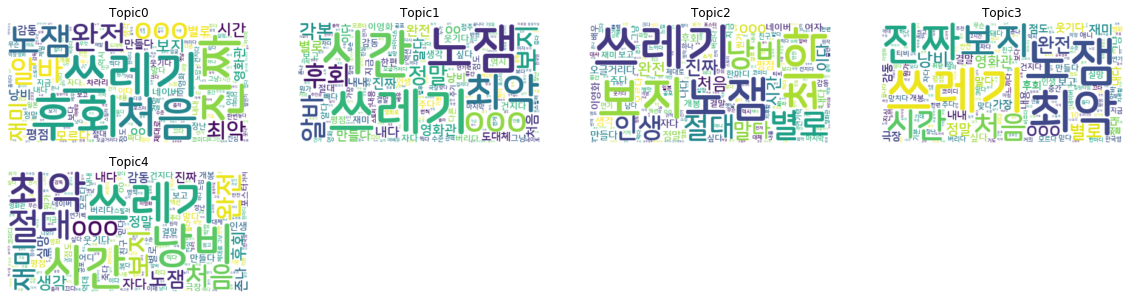

In [58]:
word_to_id = dict()
for i, v in enumerate(vocab_list):
    word_to_id[v] = i

limit = 24
n_col = 4
counter = 0

plt.figure(figsize=(20,16))
for ind in range(num_topics):

    if counter >= limit:
        break

    title_str = 'Topic{}'.format(ind)

    #pvals = mx.nd.softmax(W[:, ind]).asnumpy()
    pvals = mx.nd.softmax(mx.nd.array(W[:, ind])).asnumpy()

    word_freq = dict()
    for k in word_to_id.keys():
        i = word_to_id[k]
        word_freq[k] =pvals[i]

    # print(word_freq)
    font_path = 'NanumSquareRoundB.ttf'
    wordcloud = wc.WordCloud(background_color='white',font_path = font_path).fit_words(word_freq)

    plt.subplot(limit // n_col, n_col, counter+1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title_str)
    #plt.close()

    counter +=1
    